# Implementation of BB84 on Starmon-5

In [1]:
###                                                   IMPORTING LIBRARIES
import time
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram

from quantuminspire.credentials import get_authentication
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

from math import ceil
from itertools import product

In [14]:
###                                             CONNECTING TO QUANTUM INSPIRE
save_account('a2c6982402352e8e4b3bcabb8e89d7ec75d93003')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL,project_name='BB84 Simulation')
qi_backend = QI.get_backend('QX-34-L')                                       # <--- Set the backend (default is Starmon-5)

## Circuit construction (with quantum randomness)

In [70]:
def IntrinsicQuantumBB84Circuit(p, isEve):
   
    """
    Circuit Generator
    
    For Starmon5 purposes only
    
    p.....Probability that Eve gets the qubit
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[3])
       
    qc.measure(q[0],ans[0])
    qc.measure(q[1],ans[1])
    qc.measure(q[3],ans[2])
    
    qc.cx(q[0],q[2])
    #qc.ry(np.pi/4, q[2])
    #qc.cx(q[1],q[2])
    #qc.ry(-np.pi/4, q[2])
    #qc.cx(q[1],q[2])
    qc.cry(np.pi/2,q[1],q[2])
    
    
    if p>0 and isEve:
        qc.h(q[4])
        qc.measure(q[4],ans[4])
        qc.ch(q[4],q[2])
        qc.measure(q[2],ans[3])
        qc.ch(q[4],q[2])

    #qc.ry(np.pi/4, q[2])
    #qc.cx(q[3],q[2])
    #qc.ry(-np.pi/4, q[2])
    #qc.cx(q[3],q[2])
    
    qc.cry(-np.pi/2,q[3],q[2])
    qc.measure(q[2],ans[3])
    qc.draw()
    
    return q, qc

### Quantum circuit when there is no Eve

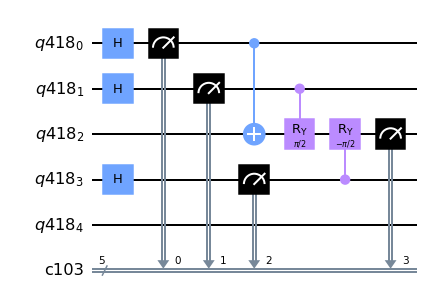

In [71]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(1, False)
quantumCircuit.draw(output='mpl')

### Quantum circuit when there is an Eve

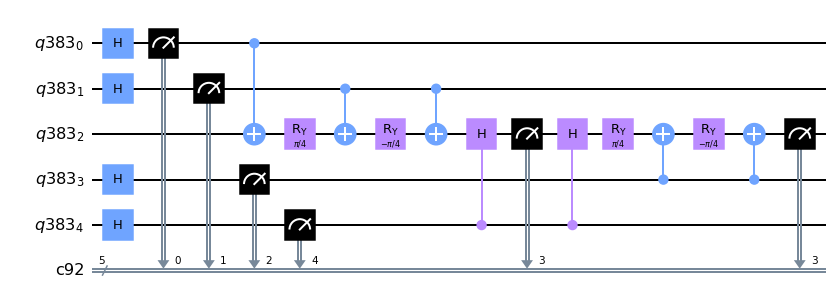

In [55]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(1, True)
quantumCircuit.draw(output='mpl')

## Function definitions

In [17]:
def BB84ProtocolQuantumRandom(messageLength, isEve, Starmon):
    """
    Given the initial message length (int) it returns
    messageInABottle: randomly generated message to be communicated (A->B)
    AliceBasis: randomly generated Alice Basis (0:Z, 1:X)
    BobBasis: randomly generated Bob Basis (0:Z, 1:X)
    OutputString: either the result from the BB84 protocol if A&B have the same basis
    or an "x" if Basis(A) != Basis(B)! for each bit
    """
    
    if Starmon:
        qi_backend = QI.get_backend('Starmon-5')
    else:
        qi_backend = QI.get_backend('QX-34-L')
    
    n = 0
    messageInABottle = []
    AliceBasis = []
    BobBasis = []
    outputString = []
    sameBasisPositions = []
    quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(1, isEve)

    job = execute(quantumCircuit, qi_backend,shots=messageLength,memory=True)
    result = job.result()
    counts = result.get_counts()
    measure = result.get_memory()
    n_register = len(measure[0])-1
    
    for n in range(messageLength):

        messageInABottle.append(int(measure[n][n_register-0]))
        AliceBasis.append(int(measure[n][n_register-1]))
        BobBasis.append(int(measure[n][n_register-2]))
        
        if AliceBasis[n] == BobBasis[n]:
            outputString.append(int(measure[n][n_register-3]))
            sameBasisPositions.append(n)
        else:
            outputString.append("x")
    

    return messageInABottle, AliceBasis, BobBasis, outputString, sameBasisPositions



In [33]:
def BB84KeyConstruction(message,output,goodIndices,prop,tolerance,explanation):
    """
    message: Alice starting message
    output: Bob's result through Quantum Magic
    goodIndices: bit Positions in which both basis are the same    
    prop: Proportion of common good bits to be compared
    tolerance: minimum success rate to generate a safe QK
    explanation: bool argument, if True, prints stuff

    """
    auxList = []    
    nGoodBits = len(goodIndices)
    
    
    nComparingBits = int(nGoodBits*prop)
    comparingBitPositions = random.sample(goodIndices, nComparingBits)
    if explanation:
        print("Bit Positions to compare: ",comparingBitPositions)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(message[j])== int(output[j]):
            allOkCounter +=1
            
    for i in range(nGoodBits):
        if i not in comparingBitPositions:
            auxList.append(output[goodIndices[i]])
    
    #print(allOkCounter)
    if nComparingBits == 0:
        successRate = 1 
    else:
        successRate = float(allOkCounter/nComparingBits)
    
    if successRate < tolerance:
        print("Success rate: ",successRate)
        print("Failure")
        return successRate
    else:
        print("Success rate: ",successRate)
        print("Success!!!")
        print("QKD: ", auxList)
        return auxList

## Protocol execution

In [73]:
messageLength = 4096
prop = 0.8
tolerance = 0.8
Eve = False
Starmon = True

messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandom(messageLength,Eve,Starmon)

QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance,explanation=False)

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5827228327228328
Failure


In [39]:
succesrates = []
for i in range(20):
    messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandom(messageLength,Eve,Starmon)
    QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance,explanation=False)
    succesrates.append(QKD)

print('Average succes rate:            ' + str(round(np.mean(succesrates),3)))
print('Standard deviation succes rate: ' + str(round(np.std(succesrates),3)))

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56884765625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58837890625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56787109375
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58544921875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58837890625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.576171875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56982421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58251953125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58642578125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5810546875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58642578125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57275390625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5830078125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5810546875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.564453125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57080078125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56640625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.556640625
Failure
Average succes rate:            0.576
Standard deviation succes rate: 0.009


# Physical error rate analysis of BB84 circuits on Starmon-5

In [3]:
def BB84Circuits(AliceBasis, BobBasis, message):
   
    """
    Circuit Generator
    
    nbits: Self-explainatory
    AliceBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    BobBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    message: nqubits-length binary array
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(1)
    qc = QuantumCircuit(q, ans)
    
    if message == 1:
        qc.x(q[2])
    qc.barrier()
    
    if (AliceBasis + BobBasis)%2 == 1:
        qc.h(q[2])

    qc.measure(q[2],ans[0])
    
    return q, qc

## All possible 1-qubit circuits in BB84

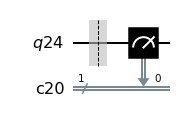

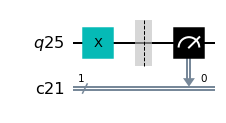

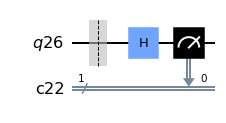

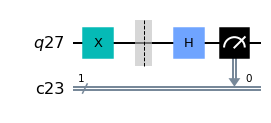

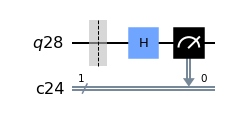

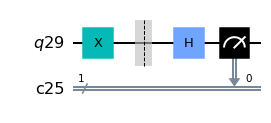

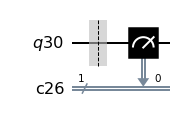

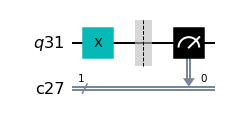

In [18]:
for AliceBasis in [0,1]:
    for BobBasis in [0,1]:
        for AliceBit in [0,1]:
            q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
            display(qc.draw(output='mpl'))

### Analyzing the error in all 8 circuits

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 0
Bob's basis: 0
Fidelity: 0.99669


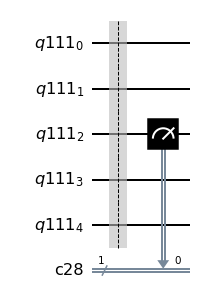

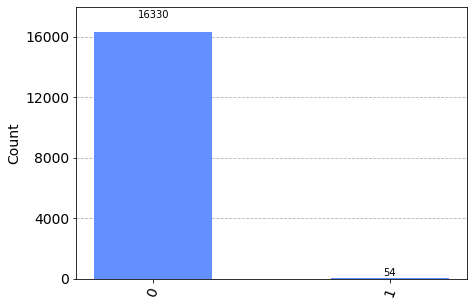

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 0
Bob's basis: 0
Fidelity: 0.95928


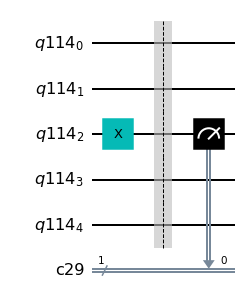

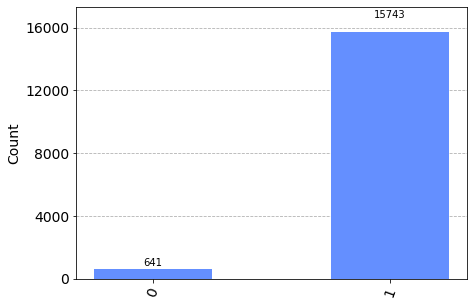

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 0
Bob's basis: 1


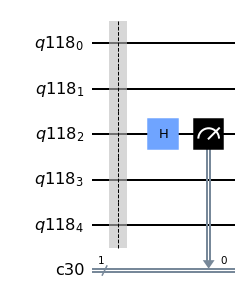

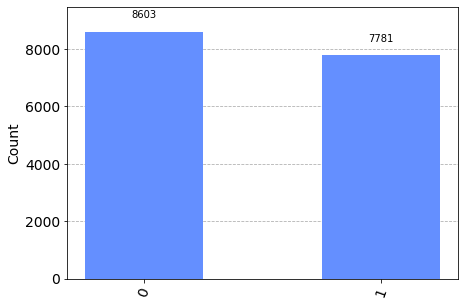

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 0
Bob's basis: 1


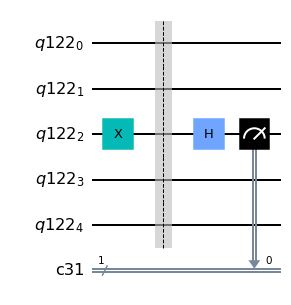

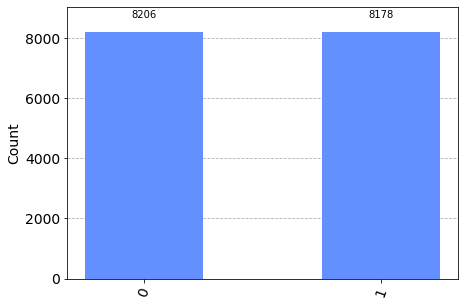

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 1
Bob's basis: 0


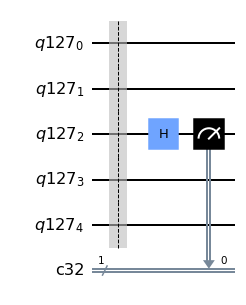

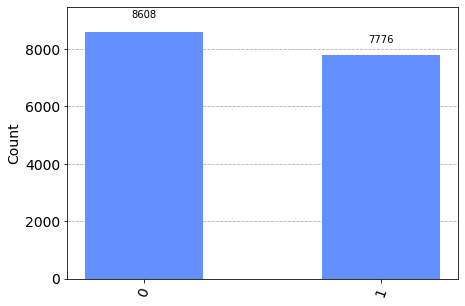

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 1
Bob's basis: 0


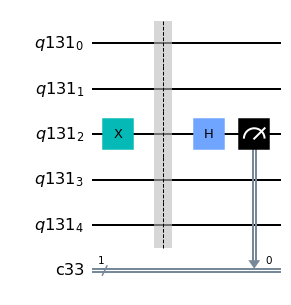

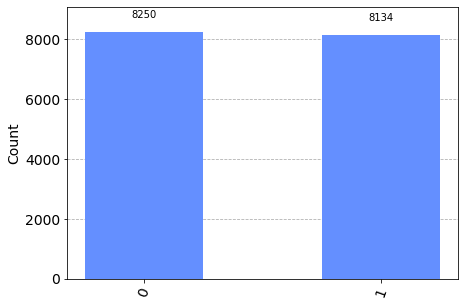

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 1
Bob's basis: 1
Fidelity: 0.99608


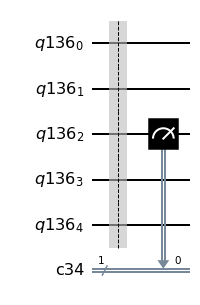

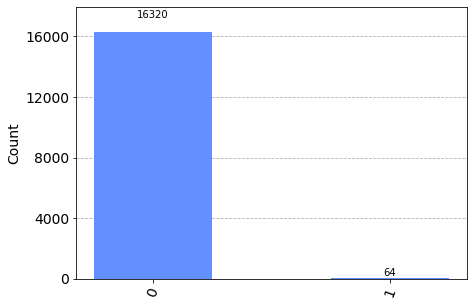

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 1
Bob's basis: 1
Fidelity: 0.95994


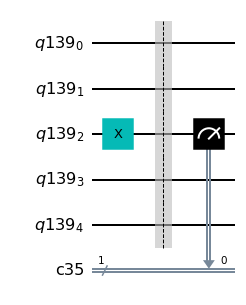

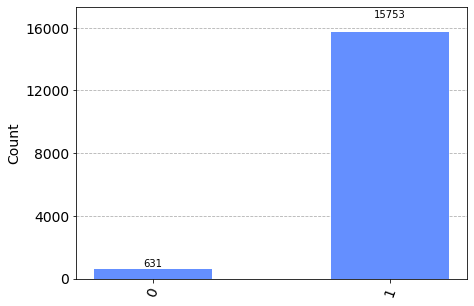

In [22]:
qi_backend = QI.get_backend('Starmon-5')

for AliceBasis in [0,1]:
    for BobBasis in [0,1]:
        for AliceBit in [0,1]:
            q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
            
            job = execute(qc, qi_backend,shots=16384)
            result = job.result()
            counts = result.get_counts()
            print("Alice's bit: "+str(AliceBit))
            print("Alice's basis: "+str(AliceBasis))
            print("Bob's basis: "+str(BobBasis))
            if BobBasis == AliceBasis:
                counts_0 = counts['0']
                counts_1 = counts['1']
                error = min(counts_0/counts_1, counts_1/counts_0)
                print("Fidelity: "+str(round(1-error,5)))
            display(qc.draw(output='mpl'))
            display(plot_histogram(result.get_counts(qc)))            